# Tutorial for SMT based Verification

As an example we try to verifiy the robustness of a classification Network trained on the iris dataset. We learn how to train a small neural network in pytorch and use the wheigts and biases to create a number of terms and formulas which can be solved by a SMT solver.


In [1]:
!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/iris_trainer.py'}
import iris_trainer

from torch import nn

# numpy
import numpy as np

# for plots
import matplotlib.pyplot as plt

# for measuring runtime
import time

# SMT solver
%pip install z3-solver
from z3 import *

--2022-05-24 13:23:42--  https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/iris_trainer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3801 (3.7K) [text/plain]
Failed to rename iris_trainer.py to iris_trainer.py.1: (2) No such file or directory
Saving to: ‘iris_trainer.py’

iris_trainer.py     100%[===================>]   3.71K  --.-KB/s    in 0s      

2022-05-24 13:23:42 (43.6 MB/s) - ‘iris_trainer.py’ saved [3801/3801]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54.5 MB 119 kB/s 


## Training of Neural Network

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [3]:
names, feature_names, X, y, X_scaled, X_train, X_test, y_train, y_test = iris_trainer.load_dataset()

model = iris_trainer.train_model(
    NeuralNetwork(input_dim=X_train.shape[1], output_dim=3, number_of_neurons=20), 
    epochs=100, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test)

Shape of X (data): (150, 4)
Shape of y (target): (150,) int64
Example of x and y pair: [5.1 3.5 1.4 0.2] 0
Shape of training set X (120, 4)
Shape of test set X (30, 4)


100%|██████████| 100/100 [00:00<00:00, 300.69it/s]


Done. Accuracy: 0.9333333333333333


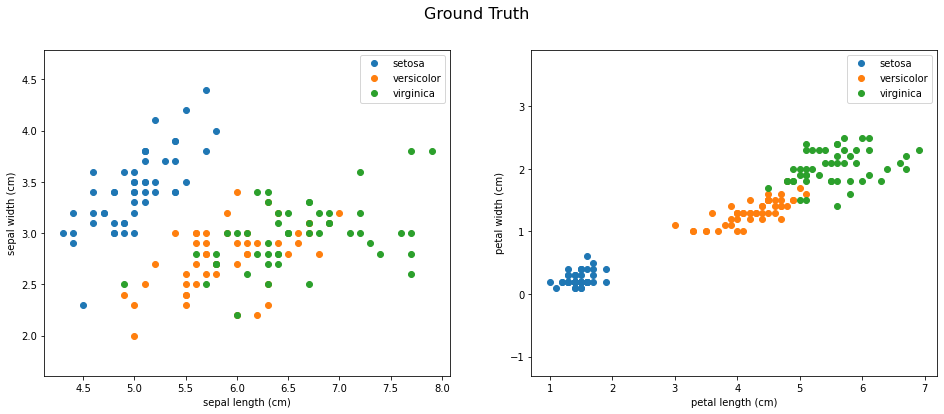

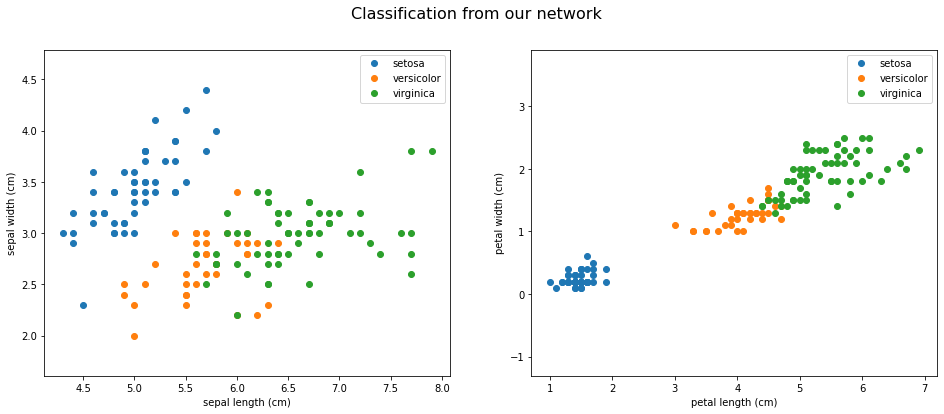

In [5]:
iris_trainer.show_plots(names, feature_names, X, y, title = 'Ground Truth')
iris_trainer.show_plots(names, feature_names, X, iris_trainer.predict(X_scaled, model), title = 'Classification from our network')

## Creating Formulas for the SMT solver

## Verifying robustness